In [1]:
import keras as ks
print(ks.backend.backend())

torch


In [2]:
%%capture
from kgcnn.data.datasets.FreeSolvDataset import FreeSolvDataset
data = FreeSolvDataset()

In [3]:
from kgcnn.graph.preprocessor import SetRange
data.map_list(SetRange(max_distance=5.0, in_place=True));
data.map_list(method="set_angle")
data.map_list(method="count_nodes_and_edges");
data.map_list(method="count_nodes_and_edges", total_edges="total_ranges", count_edges="range_indices");
data.map_list(method="count_nodes_and_edges", total_edges="total_angles", count_edges="angle_indices");

In [4]:
data[0].keys()

dict_keys(['node_symbol', 'node_number', 'edge_indices', 'edge_number', 'graph_size', 'node_coordinates', 'graph_labels', 'node_attributes', 'edge_attributes', 'graph_attributes', 'range_indices', 'range_attributes', 'angle_indices', 'angle_indices_nodes', 'angle_attributes', 'total_nodes', 'total_edges', 'total_ranges', 'total_angles'])

In [5]:
import numpy as np
labels = np.array(data.obtain_property("graph_labels"))
if len(labels.shape) <= 1:
    labels = np.expand_dims(labels, axis=-1)
total_charge = np.zeros_like(labels)  # simply assume zero charge
total_dipole = np.repeat(total_charge, 3, axis=-1)  # simply assume zero dipole
print(labels.shape, total_charge.shape, total_dipole.shape)

(642, 1) (642, 1) (642, 3)


## Charge as labels

Outputs of the model will be energy, plus dipole and charge. No additional input is needed.

In [6]:
from kgcnn.literature.HDNNP2nd import make_model_weighted

In [7]:
model_config = {
    "name": "HDNNP2nd",
    "inputs": [
        {"shape": (None,), "name": "node_number", "dtype": "int64"},
        {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32"},
        {"shape": (None, 2), "name": "range_indices", "dtype": "int64"},
        {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64"},
        {"shape": (), "name": "total_nodes", "dtype": "int64"},
        {"shape": (), "name": "total_ranges", "dtype": "int64"},
        {"shape": (), "name": "total_angles", "dtype": "int64"}
    ],
    "input_tensor_type": "padded",
    "predict_dipole": True,
    "cast_disjoint_kwargs": {},
    "w_acsf_ang_kwargs": {},
    "w_acsf_rad_kwargs": {},
    "mlp_kwargs": {"units": [128, 128, 128, 1],
                   "num_relations": 96,
                   "activation": ["swish", "swish", "swish", "linear"]},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["swish", "linear"]}
}
model = make_model_weighted(
    **model_config
)

In [8]:
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

data.clean(model_config["inputs"])
train_index, test_index = train_test_split(np.arange(len(data)), test_size=0.2)

dataset_train, dataset_test = data[train_index], data[test_index]
x_train, y_train = dataset_train.tensor(model_config["inputs"]), [y_part[train_index] for y_part in [labels, total_dipole, total_charge]]
x_test, y_test = dataset_test.tensor(model_config["inputs"]), [y_part[test_index] for y_part in [labels, total_dipole, total_charge]]

# Compile model with optimizer and loss
model.compile(loss=["mean_absolute_error"]*3, metrics=[["mean_absolute_error"]]*3, optimizer=Adam(learning_rate=5e-04))
model.summary()

# Build model with reasonable data.
model.predict(x_test, batch_size=2, steps=2)
model._compile_metrics.build(y_test, y_test)
model._compile_loss.build(y_test, y_test)

Model: "HDNNP2nd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_coordinates (InputLayer) │ (None, None, 3)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ node_number (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ range_indices (InputLayer)    │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_ranges (InputLayer)     │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ angle_indices_nodes           │ (None, None, 3)           │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_angles (InputLayer)     │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 3), (None),       │               0 │ node_coordinates[0][0],    │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │                 │ total_nodes[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None), (2, None),       │               0 │ node_number[0][0],         │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ range_indices[0][0],       │
│                               │ (None), (None), (None)]   │                 │ total_nodes[0][0],         │
│                               │                           │                 │ total_ranges[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None), (3, None),       │               0 │ node_number[0][0],         │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ angle_indices_nodes[0][0], │
│                               │ (None), (None), (None)]   │                 │ total_nodes[0][0],         │
│                               │                           │                 │ total_angles[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ w_acsf_rad (wACSFRad)         │ (None, 22)                │           5,192 │ cast_batched_indices_to_d… │
│                               │                           │                 │ cast_batched_attributes_t… │
│                               │                           │                 │ cast_batched_indices_to_d… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ w_acsf_ang (wACSFAng)         │ (None, 10)                │           4,720 │ cast_batched_indices_to_d… │
│                               │                           │               

 Total params: 3,561,531 (13.59 MB)

 Trainable params: 3,551,619 (13.55 MB)

 Non-trainable params: 9,912 (38.72 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 


In [9]:
# Start and time training
import time
from datetime import timedelta
from kgcnn.training.scheduler import LinearLearningRateScheduler
start = time.process_time()
hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 batch_size=32, 
                 epochs=300, 
                 validation_freq=10, 
                 verbose=0,  # Change to verbose = 2 to see progress
                 callbacks= [
                     LinearLearningRateScheduler(
                         learning_rate_start=0.001, learning_rate_stop=1e-05, epo_min=100, epo=300)
                 ])
stop = time.process_time()
print("Print Time for training: ", str(timedelta(seconds=stop - start)))

Print Time for training:  0:01:23.656250


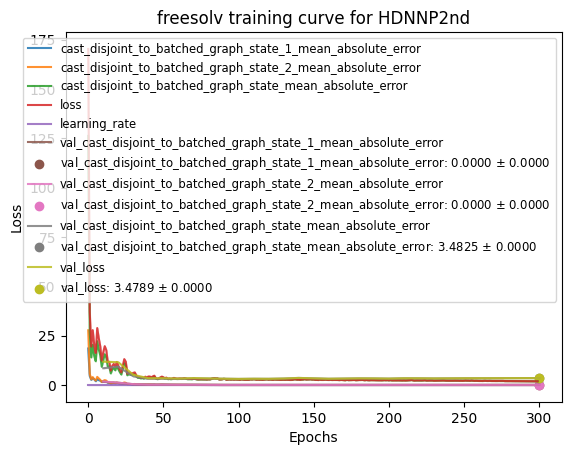

In [10]:
from kgcnn.utils.plots import plot_train_test_loss, plot_predict_true

plot_train_test_loss([hist], loss_name=None, val_loss_name=None,
                     model_name="HDNNP2nd", data_unit="", dataset_name="freesolv",
                     filepath="", file_name=f"loss.png");

## Charge as input

Total charge is needed at input. Output will be energy and dipole.

In [11]:
model_config = {
    "name": "HDNNP2nd",
    "inputs": [
        {"shape": (None,), "name": "node_number", "dtype": "int64"},
        {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32"},
        {"shape": (None, 2), "name": "range_indices", "dtype": "int64"},
        {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64"},
        {"shape": (1, ), "name": "total_charge", "dtype": "int64"},
        {"shape": (), "name": "total_nodes", "dtype": "int64"},
        {"shape": (), "name": "total_ranges", "dtype": "int64"},
        {"shape": (), "name": "total_angles", "dtype": "int64"}
    ],
    "input_tensor_type": "padded",
    "predict_dipole": True,
    "has_charge_input": True,
    "cast_disjoint_kwargs": {},
    "w_acsf_ang_kwargs": {},
    "w_acsf_rad_kwargs": {},
    "mlp_kwargs": {"units": [128, 128, 128, 1],
                   "num_relations": 96,
                   "activation": ["swish", "swish", "swish", "linear"]},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["swish", "linear"]}
}
model = make_model_weighted(
    **model_config
)

In [12]:
# add charge to data
for i, x in enumerate(data):
    x["total_charge"] = total_charge[i]
print(data[0].keys())

dict_keys(['node_symbol', 'node_number', 'edge_indices', 'edge_number', 'graph_size', 'node_coordinates', 'graph_labels', 'node_attributes', 'edge_attributes', 'graph_attributes', 'range_indices', 'range_attributes', 'angle_indices', 'angle_indices_nodes', 'angle_attributes', 'total_nodes', 'total_edges', 'total_ranges', 'total_angles', 'total_charge'])


In [13]:
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

data.clean(model_config["inputs"])
train_index, test_index = train_test_split(np.arange(len(data)), test_size=0.2)

dataset_train, dataset_test = data[train_index], data[test_index]
x_train, y_train = dataset_train.tensor(model_config["inputs"]), [y_part[train_index] for y_part in [labels, total_dipole]]
x_test, y_test = dataset_test.tensor(model_config["inputs"]), [y_part[test_index] for y_part in [labels, total_dipole]]

# Compile model with optimizer and loss
model.compile(loss=["mean_absolute_error"]*2, metrics=[["mean_absolute_error"]]*2, optimizer=Adam(learning_rate=5e-04))
model.summary()

# Build model with reasonable data.
model.predict(x_test, batch_size=2, steps=2)
model._compile_metrics.build(y_test, y_test)
model._compile_loss.build(y_test, y_test)

Model: "HDNNP2nd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_coordinates (InputLayer) │ (None, None, 3)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ node_number (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ range_indices (InputLayer)    │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_ranges (InputLayer)     │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ angle_indices_nodes           │ (None, None, 3)           │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_angles (InputLayer)     │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 3), (None),       │               0 │ node_coordinates[0][0],    │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │                 │ total_nodes[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None), (2, None),       │               0 │ node_number[0][0],         │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ range_indices[0][0],       │
│                               │ (None), (None), (None)]   │                 │ total_nodes[0][0],         │
│                               │                           │                 │ total_ranges[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None), (3, None),       │               0 │ node_number[0][0],         │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │                 │ angle_indices_nodes[0][0], │
│                               │ (None), (None), (None)]   │                 │ total_nodes[0][0],         │
│                               │                           │                 │ total_angles[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ w_acsf_rad_1 (wACSFRad)       │ (None, 22)                │           5,192 │ cast_batched_indices_to_d… │
│                               │                           │                 │ cast_batched_attributes_t… │
│                               │                           │                 │ cast_batched_indices_to_d… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ w_acsf_ang_1 (wACSFAng)       │ (None, 10)                │           4,720 │ cast_batched_indices_to_d… │
│                               │                           │               

 Total params: 3,561,531 (13.59 MB)

 Trainable params: 3,551,619 (13.55 MB)

 Non-trainable params: 9,912 (38.72 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [14]:
# Start and time training
import time
from datetime import timedelta
from kgcnn.training.scheduler import LinearLearningRateScheduler
start = time.process_time()
hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 batch_size=32, 
                 epochs=300, 
                 validation_freq=10, 
                 verbose=0,  # Change to verbose = 2 to see progress
                 callbacks= [
                     LinearLearningRateScheduler(
                         learning_rate_start=0.001, learning_rate_stop=1e-05, epo_min=100, epo=300)
                 ])
stop = time.process_time()
print("Print Time for training: ", str(timedelta(seconds=stop - start)))

Print Time for training:  0:01:20.671875


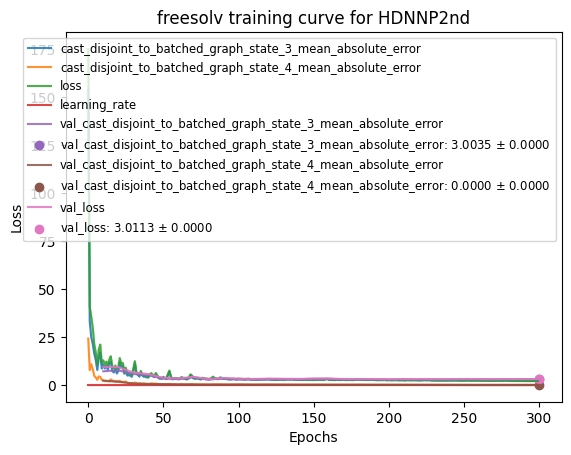

In [15]:
from kgcnn.utils.plots import plot_train_test_loss, plot_predict_true

plot_train_test_loss([hist], loss_name=None, val_loss_name=None,
                     model_name="HDNNP2nd", data_unit="", dataset_name="freesolv",
                     filepath="", file_name=f"loss.png");

In [16]:
preds = model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [18]:
preds[0][0], preds[1][0]

(array([-1.2860615], dtype=float32),
 array([-3.7679669e-07, -7.7845078e-07,  1.2414034e-06], dtype=float32))